# Time-Series Fault Detection Pipeline
**Models:** XGBoost & Random Forest
**Techniques:** ROS, RUS, SMOTE, ADASYN, Optuna Tuning
**Validation:** TimeSeriesSplit

In [1]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.2 MB/s eta 0:00:00


In [2]:
# @title 1. INSTALLATION & IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import logging
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (balanced_accuracy_score, recall_score, f1_score,
                             confusion_matrix, log_loss, precision_score,
                             precision_recall_curve, auc, fbeta_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tqdm.notebook import tqdm


# Mute Optuna logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [3]:
# Define the Graphs Style
thesis_params = {
    # Fonts
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 20,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 24,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'savefig.bbox': 'tight',
}

# Apply the settings
plt.rcParams.update(thesis_params)

# Set font size
sns.set_theme(context="paper", style="whitegrid", font_scale=1.5)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Thesis data/Processed_Dataset.csv', index_col='Timestamp', parse_dates=['Timestamp'])
df

,MT05 Supply Humidity Measurement,TV15 Control Value,MV06 Humidity Control Value,RV Outdoor Humidity,TV13 Control Value,MV13 Humidity Control Value,BP02 Control Value,MT08 Extraction Humidity Measurement,PT13 Extraction Pressure Measurement,PT12 Supply Pressure Measurement,...,TT12 Supply Temperature Measurement_roc_24h,MV10 Humidity Control Value_roc_24h,BP01 Control Value_roc_24h,TV22 Control Value_roc_24h,TT19 Supply Temperature Measurement_roc_24h,MT09 Supply Humidity Measurement_roc_24h,TV20 Control Value_roc_24h,BP03 Control Value_roc_24h,MV14 Humidity Control Control Value_roc_24h,Fault
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-02 00:00:00,61.500000,7.000000,27.000000,81.58276,0.0,0.0,65.0,39.0,-347.000000,399.750000,...,-0.086667,24.600000,0.000000,1.233333,-0.031818,-10.600000,0.0,0.000000,0.0,0
2022-01-02 00:15:00,62.000000,6.142857,26.600000,81.58276,0.0,0.0,64.0,40.0,-347.916667,399.900000,...,-0.150000,24.250000,-1.000000,-0.642857,-0.081111,-10.416667,0.0,-1.000000,0.0,0
2022-01-02 00:30:00,61.333333,6.750000,26.833333,81.58276,0.0,0.0,65.0,40.0,-347.888889,401.230769,...,-0.141818,24.166667,0.000000,0.750000,-0.032857,-10.666667,0.0,0.000000,0.0,0
2022-01-02 00:45:00,61.800000,8.166667,26.250000,81.58276,0.0,0.0,65.0,40.0,-347.500000,402.666667,...,0.065079,24.000000,0.000000,0.885714,0.024444,-10.600000,0.0,0.000000,0.0,0
2022-01-02 01:00:00,61.500000,6.333333,27.750000,81.58276,0.0,0.0,65.0,40.0,-348.285714,399.500000,...,0.055000,23.400000,0.000000,0.791667,-0.022222,-10.666667,0.0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-01 14:00:00,77.000000,20.000000,0.000000,69.55657,0.0,0.0,79.0,48.0,-352.000000,395.000000,...,0.013333,0.000000,-0.666667,-17.000000,0.016667,-1.000000,0.0,-0.666667,0.0,0
2025-09-01 14:15:00,77.000000,20.000000,0.000000,69.55657,0.0,0.0,79.0,48.0,-352.000000,395.000000,...,0.016667,0.000000,-1.000000,-18.000000,-0.083333,-1.000000,0.0,-1.000000,0.0,0
2025-09-01 14:30:00,77.000000,20.000000,0.000000,69.55657,0.0,0.0,79.0,48.0,-352.000000,395.000000,...,-0.057143,0.000000,-1.000000,-22.000000,-0.133333,-1.000000,0.0,-1.000000,0.0,0


In [6]:
# @title 2. PreProcessing

# Define features and target
X = df.drop('Fault', axis=1)
y = df['Fault']

# 80/20 Time Series Split for Final Testing
split_idx = int(len(df) * 0.8)
X_train_full, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_full, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Training set: {X_train_full.shape}, Test set: {X_test.shape}")
print(f"Test Set Fault Ratio: {y_test.mean():.4f}")

Training set: (102807, 332), Test set: (25702, 332)
Test Set Fault Ratio: 0.0062


In [7]:
# @title 3. OPTUNA OBJECTIVE

# This function handles the TimeSeriesSplit CV and Hyperparameter search
def objective(trial, model_type, sampler_type, X, y):
    if sampler_type == 'None': sampler = None
    elif sampler_type == 'ROS': sampler = RandomOverSampler(random_state=42)
    elif sampler_type == 'RUS': sampler = RandomUnderSampler(random_state=42)
    elif sampler_type == 'SMOTE': sampler = SMOTE(random_state=42)
    elif sampler_type == 'ADASYN':
        try: sampler = ADASYN(random_state=42)
        except: sampler = RandomOverSampler(random_state=42)

    # Define model and Hyperparameters
    if model_type == 'XGBoost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 400),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 20),
            'tree_method': 'hist',
            'objective': 'binary:logistic', 'eval_metric': 'logloss',
            'n_jobs': -1, 'verbosity': 0, 'random_state': 42
        }
        model = xgb.XGBClassifier(**params)
    elif model_type == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
            'n_jobs': -1, 'random_state': 42
        }
        model = RandomForestClassifier(**params)

    # TimeSeries Cross-Validation
    tscv = TimeSeriesSplit(n_splits=3) # Reduced to 3 for speed
    scores = []

    # Use ImbPipeline to ensure resampling happens ONLY on the train fold
    # and not on the validation fold
    for train_idx, val_idx in tscv.split(X):
        X_f_train, X_f_val = X.iloc[train_idx], X.iloc[val_idx]
        y_f_train, y_f_val = y.iloc[train_idx], y.iloc[val_idx]

        steps = [('scaler', StandardScaler())]
        if sampler: steps.append(('sampler', sampler))
        steps.append(('model', model))
        pipeline = ImbPipeline(steps=steps)
        pipeline.fit(X_f_train, y_f_train)

        preds_proba = pipeline.predict_proba(X_f_val)[:, 1]
        try: score = log_loss(y_f_val, preds_proba)
        except: score = 10
        scores.append(score)

    return np.mean(scores)

In [8]:
# @title 4. MAIN EXECUTION LOOP (PR Curve Optimization)

#Configurations
models = ['XGBoost', 'RandomForest']
samplers = ['None', 'ROS', 'RUS', 'SMOTE', 'ADASYN']

best_results_df = pd.DataFrame()
pr_curves_data = {} # To store curve data for plotting
best_params_dict = {}

combinations = [(m, s) for m in models for s in samplers]
pbar = tqdm(combinations, desc="Overall Progress")

print("Starting Training & PR Curve Optimization...")

for model_name, sampler_name in pbar:
    run_name = f"{model_name}_{sampler_name}"
    pbar.set_description(f"Processing: {run_name}")

    # 1. Hyperparameter Search
    sampler = optuna.samplers.TPESampler(seed=42)

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda t: objective(t, model_name, sampler_name, X_train_full, y_train_full),
                   n_trials=30, show_progress_bar=False)
    best_params = study.best_params

    best_params_dict[run_name] = best_params

    # 2. Train Final Model
    if sampler_name == 'None': sampler = None
    elif sampler_name == 'ROS': sampler = RandomOverSampler(random_state=42)
    elif sampler_name == 'RUS': sampler = RandomUnderSampler(random_state=42)
    elif sampler_name == 'SMOTE': sampler = SMOTE(random_state=42)
    elif sampler_name == 'ADASYN':
        try: sampler = ADASYN(random_state=42)
        except: sampler = RandomOverSampler(random_state=42)

    if model_name == 'XGBoost':
        clf = xgb.XGBClassifier(**best_params, tree_method='hist', objective='binary:logistic', eval_metric='logloss', n_jobs=-1, random_state=42)
    else:
        clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)

    pipeline = ImbPipeline(steps=[('scaler', StandardScaler()), ('sampler', sampler), ('model', clf)] if sampler
                           else [('scaler', StandardScaler()), ('model', clf)])

    pipeline.fit(X_train_full, y_train_full)

    # 3. Predict Probabilities
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # 4. FIND OPTIMAL THRESHOLD via PR Curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

    # --- CHANGE: CALCULATE F-BETA INSTEAD OF F1 ---
    beta = 2.0  # <--- USER CONFIG: Recall is 2x more important than Precision

    numerator = (1 + beta**2) * (precisions * recalls)
    denominator = (beta**2 * precisions) + recalls

    # Handle division by zero (if precision+recall = 0)
    fbeta_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)

    # Find index of Max F-Beta
    best_idx = np.argmax(fbeta_scores)

    # Corresponding metrics
    best_score = fbeta_scores[best_idx] # This is now F2, not F1
    best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    best_precision = precisions[best_idx]
    best_recall = recalls[best_idx]

    # 5. Generate Final Predictions using Optimal Threshold
    y_pred_opt = (y_prob >= best_thresh).astype(int)

    # Store Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()

    # Save Results
    best_results_df = pd.concat([best_results_df, pd.DataFrame({
        'Model': [model_name], 'Sampler': [sampler_name], 'Run_ID': [run_name],
        'Optimal_Threshold': [best_thresh], 'Max_F2': [best_score],
        'Precision': [best_precision], 'Recall': [best_recall],
        'TP': [tp], 'TN': [tn], 'FP': [fp], 'FN': [fn]
    })], ignore_index=True)


    # Store full curve for final plotting
    pr_curves_data[run_name] = {
        'precision': precisions,
        'recall': recalls,
        'auc': auc(recalls, precisions)
    }

print("\nProcessing Complete.")

Overall Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Starting Training & PR Curve Optimization...

Processing Complete.



=== FINAL RESULTS (Optimized by Max F2 on PR Curve) ===
          Model Sampler  Optimal_Threshold    Max_F2    Recall  Precision   TP  FN
0       XGBoost    None           0.076299  0.782984  0.798742   0.725714  127  32
1       XGBoost     ROS           0.191148  0.748731  0.742138   0.776316  118  41
2       XGBoost     RUS           0.745195  0.753920  0.786164   0.647668  125  34
3       XGBoost   SMOTE           0.397460  0.784191  0.786164   0.776398  125  34
4       XGBoost  ADASYN           0.296688  0.722820  0.761006   0.601990  121  38
5  RandomForest    None           0.231399  0.784672  0.811321   0.693548  129  30
6  RandomForest     ROS           0.214608  0.808019  0.836478   0.711230  133  26
7  RandomForest     RUS           0.538510  0.800000  0.830189   0.698413  132  27
8  RandomForest   SMOTE           0.327271  0.774566  0.842767   0.585153  134  25
9  RandomForest  ADASYN           0.332686  0.718954  0.830189   0.468085  132  27

Plotting Confusion Matrices (

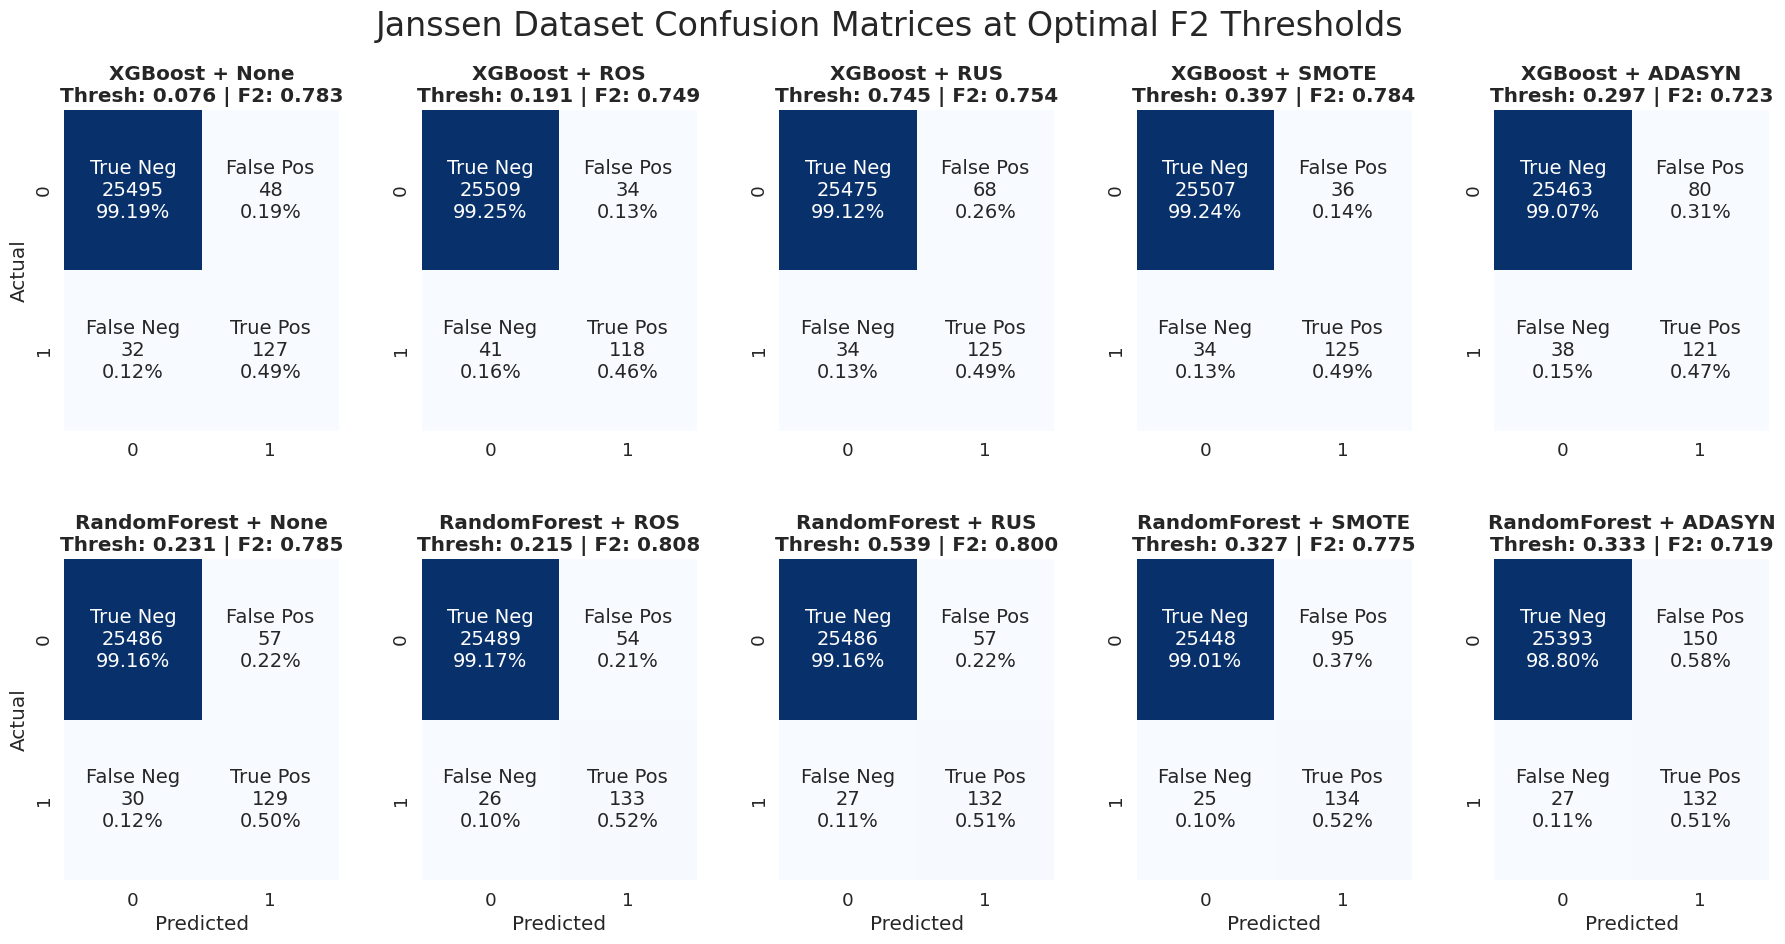

In [9]:
# @title 7. REPORTING (Tables & Confusion Matrix Grid)

# Logical Sorting
model_order = ['XGBoost', 'RandomForest']
sampler_order = ['None', 'ROS', 'RUS', 'SMOTE', 'ADASYN']
best_results_df['Model'] = pd.Categorical(best_results_df['Model'], categories=model_order, ordered=True)
best_results_df['Sampler'] = pd.Categorical(best_results_df['Sampler'], categories=sampler_order, ordered=True)
logical_df = best_results_df.sort_values(by=['Model', 'Sampler'])

print("\n=== FINAL RESULTS (Optimized by Max F2 on PR Curve) ===")
print(logical_df[['Model', 'Sampler', 'Optimal_Threshold', 'Max_F2', 'Recall', 'Precision', 'TP', 'FN']]
      .reset_index(drop=True).to_string())

# --- PLOT 1: Confusion Matrix Grid ---
print("\nPlotting Confusion Matrices (At Optimal Thresholds)...")
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(22, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
axes_flat = axes.flatten()

for i, (model, sampler) in enumerate([(m, s) for m in model_order for s in sampler_order]):
    ax = axes_flat[i]
    row = best_results_df[(best_results_df['Model'] == model) & (best_results_df['Sampler'] == sampler)].iloc[0]

    cm_matrix = np.array([[int(row['TN']), int(row['FP'])], [int(row['FN']), int(row['TP'])]])

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_matrix.flatten()/np.sum(cm_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cm_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, ax=ax, annot_kws={"size": 14})
    ax.set_title(f"{model} + {sampler}\nThresh: {row['Optimal_Threshold']:.3f} | F2: {row['Max_F2']:.3f}", fontweight='bold')
    if i % 5 == 0: ax.set_ylabel('Actual')
    if i >= 5: ax.set_xlabel('Predicted')

plt.suptitle("Janssen Dataset Confusion Matrices at Optimal F2 Thresholds")
plt.savefig("Confusion Matrices Janssen.pdf")
plt.show()


Plotting Combined Precision-Recall Curves...


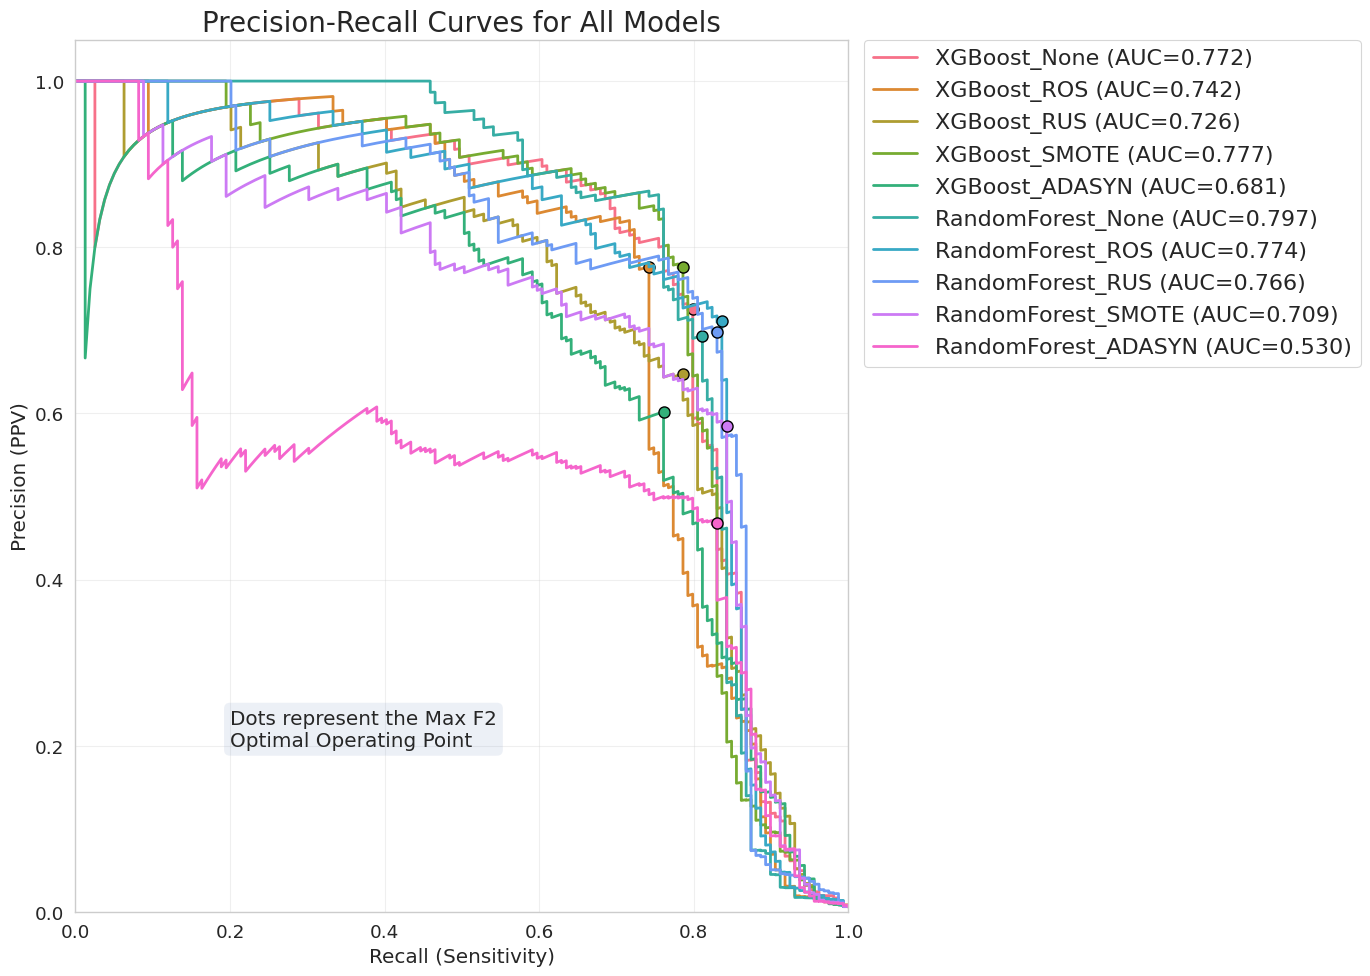

In [10]:
# @title 8. PLOT 2: COMBINED PRECISION-RECALL CURVE
print("\nPlotting Combined Precision-Recall Curves...")
plt.figure(figsize=(14, 10))

# Define colors/markers for distinction
colors = sns.color_palette("husl", 10)
lines = []

for i, (run_name, data) in enumerate(pr_curves_data.items()):
    # Get model specifics for legend
    auc_score = data['auc']
    p, r = data['precision'], data['recall']

    # Plot line
    l, = plt.plot(r, p, color=colors[i], lw=2, label=f'{run_name} (AUC={auc_score:.3f})')
    lines.append(l)

    # Mark the Optimal Point (Max F2)
    # We find the specific point in the saved df
    row = best_results_df[best_results_df['Run_ID'] == run_name].iloc[0]
    plt.plot(row['Recall'], row['Precision'], marker='o', color=colors[i], markersize=8, markeredgecolor='black')

plt.title('Precision-Recall Curves for All Models', fontsize=20)
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, fontsize=16)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Add explanation annotation
plt.text(0.2, 0.2, "Dots represent the Max F2\nOptimal Operating Point",
         bbox=dict(boxstyle="round", alpha=0.1))

plt.tight_layout()
plt.savefig("PR Janssen.pdf")
plt.show()

WINNING MODEL: RandomForest_ROS
Performance (F2): 0.8080
Retraining winner for feature extraction...


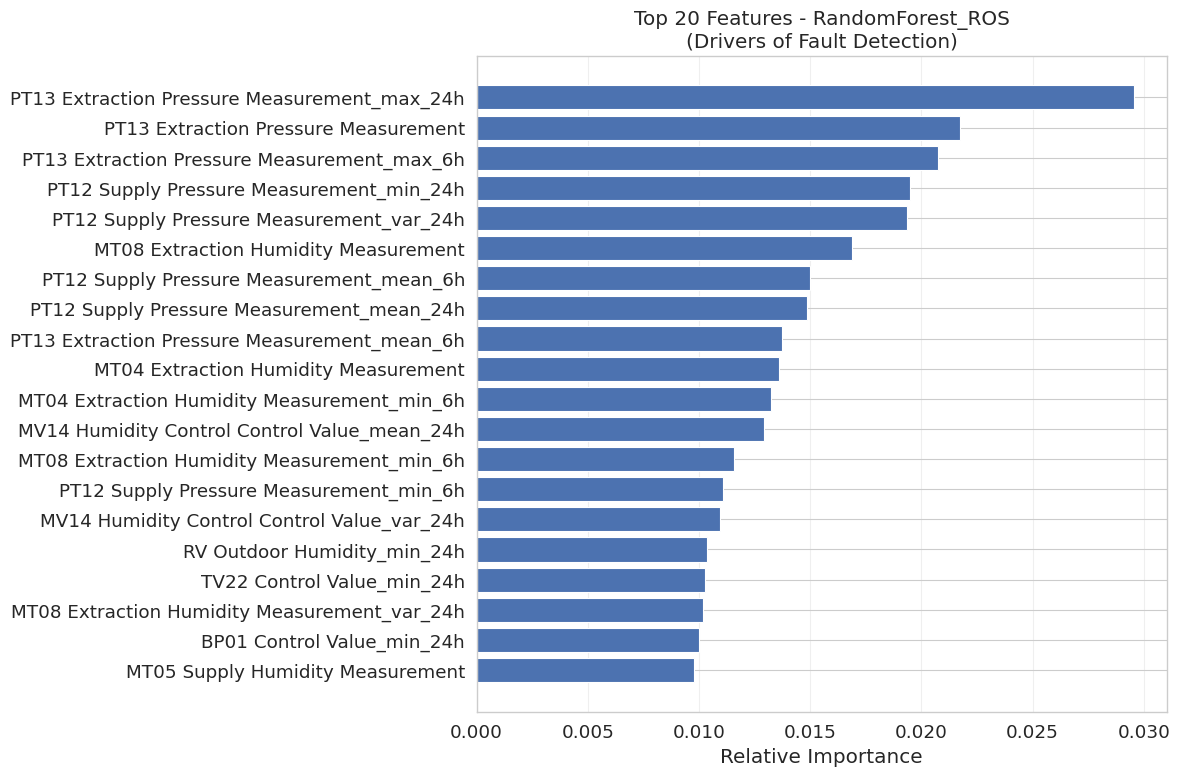


--- INTERPRETATION ---
The most dominant feature is 'PT13 Extraction Pressure Measurement_max_24h'.


In [11]:
# @title 9. FEATURE IMPORTANCE ANALYSIS (Top 20 of Winning Model)

# Identify the Winning Model (Highest F-Beta Score)
# We sort by the specific metric we optimized for (Max_F2)
best_row = best_results_df.sort_values(by=f'Max_F2', ascending=False).iloc[0]

winner_name = best_row['Run_ID']
winner_model_type = best_row['Model']
winner_sampler = best_row['Sampler']
winner_score = best_row[f'Max_F2']

print(f"WINNING MODEL: {winner_name}")
print(f"Performance (F2): {winner_score:.4f}")

# Retrieve Optimal Hyperparameters
# (Assumes best_params_dict was populated in the training loop)
try:
    params = best_params_dict[winner_name]
except KeyError:
    print("Error: 'best_params_dict' not found or empty. Please ensure you saved params in the loop.")
    # Fallback to default params if necessary just to show the plot
    params = {'n_estimators': 100, 'max_depth': 5}

# Re-instantiate the Model & Sampler
if winner_model_type == 'XGBoost':
    clf = xgb.XGBClassifier(**params, tree_method='hist', objective='binary:logistic',
                            eval_metric='logloss', n_jobs=-1, random_state=42)
else:
    clf = RandomForestClassifier(**params, n_jobs=-1, random_state=42)

# Select Sampler
if winner_sampler == 'None': sampler = None
elif winner_sampler == 'ROS': sampler = RandomOverSampler(random_state=42)
elif winner_sampler == 'RUS': sampler = RandomUnderSampler(random_state=42)
elif winner_sampler == 'SMOTE': sampler = SMOTE(random_state=42)
elif winner_sampler == 'ADASYN':
    try: sampler = ADASYN(random_state=42)
    except: sampler = RandomOverSampler(random_state=42)

# Fit the Model (Recalculating on Full Train Data)
# We handle scaling/sampling manually here to keep track of column names
print("Retraining winner for feature extraction...")

X_temp = X_train_full.copy()
y_temp = y_train_full.copy()

# Scale
scaler = StandardScaler()
X_temp_scaled = scaler.fit_transform(X_temp)
# Keep column names! (StandardScaler returns numpy array)
X_temp_df = pd.DataFrame(X_temp_scaled, columns=X_temp.columns)

# Sample
if sampler:
    X_res, y_res = sampler.fit_resample(X_temp_df, y_temp)
else:
    X_res, y_res = X_temp_df, y_temp

# Fit
clf.fit(X_res, y_res)

# Extract Feature Importances
importances = clf.feature_importances_
feature_names = X_train_full.columns

# Sort indices by importance (High to Low)
indices = np.argsort(importances)[::-1]

# Slice Top 20
top_n = 20
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_names = [feature_names[i] for i in top_indices]

# Plotting
plt.figure(figsize=(12, 8))
# Invert y-axis for "Top to Bottom" look
plt.barh(range(top_n), top_importances, color='#4c72b0', align='center')
plt.yticks(range(top_n), top_names)
plt.gca().invert_yaxis()
plt.xlabel('Relative Importance')
plt.title(f'Top {top_n} Features - {winner_name}\n(Drivers of Fault Detection)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig("Feature Importance Janssen.pdf")
plt.show()

# Interpretation Text
print("\n--- INTERPRETATION ---")
print(f"The most dominant feature is '{top_names[0]}'.")